In [38]:
import allel  # type: ignore
import dask
import numba  # type: ignore
import numpy as np
import pandas as pd
import plotly.express as px  # type: ignore
import plotly.graph_objects as go  # type: ignore
import xarray as xr
import sgkit as sg

df_samples = pd.read_table('/Users/dennistpw/Projects/AsGARD/metadata/cease_combinedmetadata.20250715.txt')

In [43]:
#define stevegen1000 functions
def select_random_genos(
                    ds, 
                    numgenos=100_000):
                     #selects given number of genos at random
                    keep_indices = np.random.choice(ds.call_genotype.shape[0], numgenos, replace=False)
                    keep_indices.sort()
                    thinned_callset = ds.isel(variants=~keep_indices)
                    return(thinned_callset)

def load_geno_ds(chrom, 
                sample_query=None, 
                numgenos=None, 
                sample_list=None, 
                start=None, 
                end=None, 
                min_minor_ac=None,
                df_samples=df_samples):
                 # load sample metadata
     #load ds
     ds = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.CM023248.zarr')

     if sample_query:
          # locate selected samples
          loc_samples = df_samples.eval(sample_query).values
          df_samples = df_samples.loc[loc_samples, :]
          ds = ds.isel(samples=loc_samples)
     elif sample_list:
          loc_samples = df_samples['sample_id'].isin(sample_list)
          df_samples = df_samples.loc[loc_samples, :]
          ds = ds.isel(samples=loc_samples)
     else:
          pass
          
     #if numgenos is set, subset 
     if numgenos:
          ds_analysis = select_random_genos(ds)
     else:
          ds_analysis = ds

     #if region is set, subset to region
     if start:
               #subset to region of interest
              print(f"subsetting haps to range {chrom}:{start}-{end}")
              ds_analysis = ds_analysis.set_index(variants=("variant_contig", "variant_position")).sel(variants=(0, slice(start,end)))
     else:
            pass
     
     #if minmaf is specified, select minmaf  
     if min_minor_ac:   
        print(f'subsetting to segregating sites')
        ac = allel.GenotypeArray(ds_analysis['call_genotype']).count_alleles()
        macbool = ac[:,1] >= min_minor_ac
        print(f'selected {np.sum(macbool)} sites with a min mac > {min_minor_ac}')
        ds_analysis = ds_analysis.sel(variants=(macbool))

     #get accessible only
     print('subsetting to accessible sites only')
     accmask = ds_analysis['is_accessible'].compute()
     ds_analysis = ds_analysis.sel(variants=(accmask))

     #return completed ds
     return(df_samples, ds_analysis)

def jackknife_ci(stat_data, jack_stat, confidence_level):
    """Compute a confidence interval from jackknife resampling.

    Parameters
    ----------
    stat_data : scalar
        Value of the statistic computed on all data.
    jack_stat : ndarray
        Values of the statistic computed for each jackknife resample.
    confidence_level : float
        Desired confidence level (e.g., 0.95).

    Returns
    -------
    estimate
        Bias-corrected "jackknifed estimate".
    bias
        Jackknife bias.
    std_err
        Standard error.
    ci_err
        Size of the confidence interval.
    ci_low
        Lower limit of confidence interval.
    ci_upp
        Upper limit of confidence interval.

    Notes
    -----
    N.B., this implementation is based on code from astropy, see:

    https://github.com/astropy/astropy/blob/8aba9632597e6bb489488109222bf2feff5835a6/astropy/stats/jackknife.py#L55

    """
    from scipy.special import erfinv  # type: ignore

    n = len(jack_stat)

    mean_jack_stat = np.mean(jack_stat)

    # jackknife bias
    bias = (n - 1) * (mean_jack_stat - stat_data)

    # jackknife standard error
    std_err = np.sqrt(
        (n - 1) * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat))
    )

    # bias-corrected "jackknifed estimate"
    estimate = stat_data - bias

    # confidence interval
    z_score = np.sqrt(2.0) * erfinv(confidence_level)
    ci_err = 2 * z_score * std_err
    ci_low, ci_upp = estimate + z_score * np.array((-std_err, std_err))

    return estimate, bias, std_err, ci_err, ci_low, ci_upp

def block_jackknife_cohort_diversity_stats(
    cohort_label, ac, n_jack, confidence_level, chromlen
    ):

        n_sites = ac.shape[0]
        ac = allel.AlleleCountsArray(ac)
        n = ac.sum(axis=1).max()  # number of chromosomes sampled
        n_sites = min(n_sites, ac.shape[0])  # number of sites
        block_length = n_sites // n_jack  # number of sites in each block
        n_sites_j = n_sites - block_length  # number of sites in each jackknife resample
        length_contig_j = chromlen - (chromlen // n_jack) # length of the contig minus the jacknife block size

        a1 = np.sum(1 / np.arange(1, n))
        a2 = np.sum(1 / (np.arange(1, n) ** 2))
        b1 = (n + 1) / (3 * (n - 1))
        b2 = 2 * (n**2 + n + 3) / (9 * n * (n - 1))
        c1 = b1 - (1 / a1)
        c2 = b2 - ((n + 2) / (a1 * n)) + (a2 / (a1**2))
        e1 = c1 / a1
        e2 = c2 / (a1**2 + a2)

        mpd_data = allel.mean_pairwise_difference(ac, fill=0)
        # N.B., here we compute the number of segregating sites as the number
        # of alleles minus 1. This follows the sgkit and tskit implementations,
        # and is different from scikit-allel.
        seg_data = ac.allelism() - 1

        theta_pi_abs_data = np.sum(mpd_data)
        theta_pi_data = theta_pi_abs_data / chromlen
        S_data = np.sum(seg_data)
        theta_w_abs_data = S_data / a1
        theta_w_data = theta_w_abs_data / n_sites
        d_data = theta_pi_abs_data - theta_w_abs_data
        d_stdev_data = np.sqrt((e1 * S_data) + (e2 * S_data * (S_data - 1)))
        tajima_d_data = d_data / d_stdev_data

        jack_theta_pi = []
        jack_theta_w = []
        jack_tajima_d = []

        for i in range(n_jack):
            # locate block to delete
            block_start = i * block_length
            block_stop = block_start + block_length
            loc_j = np.ones(n_sites, dtype=bool)
            loc_j[block_start:block_stop] = False
            assert np.count_nonzero(loc_j) == n_sites_j

            # resample data and compute statistics

            # theta_pi
            mpd_j = mpd_data[loc_j]
            theta_pi_abs_j = np.sum(mpd_j)
            theta_pi_j = theta_pi_abs_j / length_contig_j
            jack_theta_pi.append(theta_pi_j)

            # theta_w
            seg_j = seg_data[loc_j]
            S_j = np.sum(seg_j)
            theta_w_abs_j = S_j / a1
            theta_w_j = theta_w_abs_j / length_contig_j
            jack_theta_w.append(theta_w_j)

            # tajima_d
            d_j = theta_pi_abs_j - theta_w_abs_j
            d_stdev_j = np.sqrt((e1 * S_j) + (e2 * S_j * (S_j - 1)))
            tajima_d_j = d_j / d_stdev_j
            jack_tajima_d.append(tajima_d_j)

        # calculate jackknife stats
        (
            theta_pi_estimate,
            theta_pi_bias,
            theta_pi_std_err,
            theta_pi_ci_err,
            theta_pi_ci_low,
            theta_pi_ci_upp,
        ) = jackknife_ci(
            stat_data=theta_pi_data,
            jack_stat=jack_theta_pi,
            confidence_level=confidence_level,
        )
        (
            theta_w_estimate,
            theta_w_bias,
            theta_w_std_err,
            theta_w_ci_err,
            theta_w_ci_low,
            theta_w_ci_upp,
        ) = jackknife_ci(
            stat_data=theta_w_data,
            jack_stat=jack_theta_w,
            confidence_level=confidence_level,
        )
        (
            tajima_d_estimate,
            tajima_d_bias,
            tajima_d_std_err,
            tajima_d_ci_err,
            tajima_d_ci_low,
            tajima_d_ci_upp,
        ) = jackknife_ci(
            stat_data=tajima_d_data,
            jack_stat=jack_tajima_d,
            confidence_level=confidence_level,
        )

        return dict(
            cohort=cohort_label,
            theta_pi=theta_pi_data,
            theta_pi_estimate=theta_pi_estimate,
            theta_pi_bias=theta_pi_bias,
            theta_pi_std_err=theta_pi_std_err,
            theta_pi_ci_err=theta_pi_ci_err,
            theta_pi_ci_low=theta_pi_ci_low,
            theta_pi_ci_upp=theta_pi_ci_upp,
            theta_w=theta_w_data,
            theta_w_estimate=theta_w_estimate,
            theta_w_bias=theta_w_bias,
            theta_w_std_err=theta_w_std_err,
            theta_w_ci_err=theta_w_ci_err,
            theta_w_ci_low=theta_w_ci_low,
            theta_w_ci_upp=theta_w_ci_upp,
            tajima_d=tajima_d_data,
            tajima_d_estimate=tajima_d_estimate,
            tajima_d_bias=tajima_d_bias,
            tajima_d_std_err=tajima_d_std_err,
            tajima_d_ci_err=tajima_d_ci_err,
            tajima_d_ci_low=tajima_d_ci_low,
            tajima_d_ci_upp=tajima_d_ci_upp,
        )
def cohort_diversity_stats(
        chrom,
        chromlen,
        sample_query,
        cohort_label,
        random_seed = 42,
        n_jack= 200,
        confidence_level = 0.95,
    ):
    

        #load ds
        df_samples, ds = load_geno_ds(chrom=chrom,
                     sample_query=sample_query,
                     )
        print('loaded ds')
        ac = allel.GenotypeArray(ds['call_genotype'].compute()).count_alleles()

        stats = block_jackknife_cohort_diversity_stats(
            cohort_label=cohort_label,
            chromlen=chromlen,
            ac=ac,
            n_jack=n_jack,
            confidence_level=confidence_level,
        )

        extra_fields = [
            ("location", "unique"),
            ("country", "unique"),
            ("longitude", "mean"),
            ("latitude", "mean"),
        ]
        for field, agg in extra_fields:
            if agg == "unique":
                vals = df_samples[field].dropna().sort_values().unique()
                if len(vals) == 0:
                    val = np.nan
                elif len(vals) == 1:
                    val = vals[0]
                else:
                    val = vals.tolist()
            elif agg == "mean":
                vals = df_samples[field].dropna()
                if len(vals) == 0:
                    val = np.nan
                else:
                    val = np.mean(vals)
            else:
                val = np.nan
            stats[field] = val

        return pd.Series(stats)

def diversity_stats(
    chrom,
    chromlen,
    sample_query,
    cohort_label,
    random_seed = 42,
    n_jack= 200,
    confidence_level =  0.95,
):

    # Compute diversity stats for cohorts.
    stats = cohort_diversity_stats(
        chrom,
        chromlen,
        sample_query,
        cohort_label, 
        random_seed=random_seed,
        n_jack=n_jack,
        confidence_level=confidence_level
    )
    df_stats = pd.DataFrame(stats)

    return df_stats

In [44]:
thetdf = diversity_stats(chrom='CM023248',
                        chromlen=93706023,
                        sample_query=f'pop_code == "APA" & (sample_id != "M18" & sample_id != "M08")',
                        cohort_label="APA")

subsetting to accessible sites only
loaded ds


In [45]:
thetdf

,0
cohort,APA
theta_pi,0.010709
theta_pi_estimate,0.010709
theta_pi_bias,0.0
theta_pi_std_err,0.000123
theta_pi_ci_err,0.000484
theta_pi_ci_low,0.010467
theta_pi_ci_upp,0.01095
theta_w,0.12157
theta_w_estimate,21.77142


In [36]:
# Limited pop codes for dirus paper
dflist = []
for pop in ['APA']:
    thetdf = diversity_stats(chrom='CM023248',
                             chromlen=93706023,
                             sample_query=f'pop_code == "{pop}" & (sample_id != "M18" & sample_id != "M08")',
                             cohort_label=pop)
    dflist.append(thetdf)

IndexError: Boolean array size 22 is used to index array with shape (10102313, 601, 2).

In [11]:
pd.concat(dflist, axis=1).to_csv('/Users/dennistpw/github/vobs-asia/work/dirus-popgen-2025-05-20/stephensi_thetas.csv')

In [14]:
pd.concat(dflist, axis=1)

,0,0,0
cohort,APA,DJI,SUD
theta_pi,0.010709,0.009163,0.008019
theta_pi_estimate,-18.134427,-15.516243,-13.580377
theta_pi_bias,18.145136,15.525406,13.588396
theta_pi_std_err,0.001174,0.001083,0.00094
theta_pi_ci_err,0.004603,0.004246,0.003686
theta_pi_ci_low,-18.136728,-15.518366,-13.58222
theta_pi_ci_upp,-18.132126,-15.51412,-13.578534
theta_w,0.12157,0.076615,0.040058
theta_w_estimate,0.121571,0.076615,0.040058


In [18]:
dflist = []
for pop in df_samples.pop_code.unique():
    thetdf = diversity_stats(chrom='CM023248',
                             chromlen=93706023,
                             sample_query=f'pop_code == "{pop}" & (sample_id != "M18" & sample_id != "M08")',
                             cohort_label=pop)
    dflist.append(thetdf)

subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_88561/1018325755.py:156: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_data = d_data / d_stdev_data
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_88561/1018325755.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_j = d_j / d_stdev_j
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_88561/1018325755.py:106: RuntimeWarning: invalid value encountered in scalar subtract
  bias = (n - 1) * (mean_jack_stat - stat_data)
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_88561/1018325755.py:110: RuntimeWarning: invalid value encountered in subtract
  (n - 1) * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat))


subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds


In [23]:
pidf = pd.concat(dflist, axis=1)


#palettes
#palettes
pop_code_cols = {
    'SAE' : '#6a3d9a', #dark purple
    'SAR' : '#cab2d6', #ligher purple
    'IRS' : '#c27a88', #not sure yet
    'IRH' : '#c57fc9', #not sure yet
    'INB' : '#96172e', #darkred
    'INM' : '#f03e5e', #lightred
    'APA' : '#ff7f00', #orange
    'DJI' : '#507d2a', #sap green
    'ETN' : '#007272', #cobalt turq
    'ETS' : '#a6cee3',#cerulean
    'SUD' : '#fccf86',#ochre
    'YEM' : '#CC7722',#pinkish
    'KEN' : '#04309b',
    #'COL' : '#080808'
}


In [24]:
pidf.columns = list(pidf.iloc[0])
pidf = pidf.drop('COL', axis=1)

/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_88561/2929222989.py:14: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(


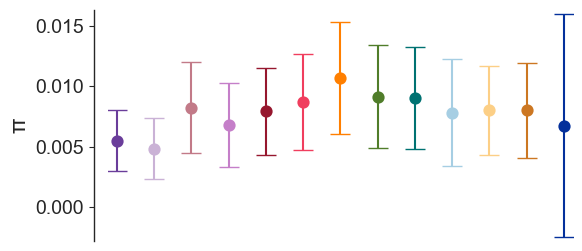

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker


## Plot pi

sns.set_style("ticks")
plt.figure(figsize=(6, 3))
# Pivot to long
pi_long = pidf.iloc[0:8].T 

# Plot pi
ax = sns.pointplot(
    x='cohort',
    y='theta_pi',
    data=pi_long,
    errorbar=None,
    order=pop_code_cols.keys(),
    capsize=5,
    join=False,
    palette=pop_code_cols,
    hue='cohort'
)

# Plot error bars
for pop in pop_code_cols:
    row = pi_long[pi_long['cohort'] == pop]
    plt.errorbar(
        row['cohort'],
        row['theta_pi'],
        yerr=row['theta_pi_ci_err'],
        fmt='o',
        color=pop_code_cols[pop],
        capsize=7
    )


# Format axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)

#ax.spines['left'].set_bounds(0.005,0.013)

#ax.set_yticks(ticks)  # Remove x-ticks
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.spines['left'].set_position(('outward', 10))  # Move the left spine further to the left

# Remove x-axis completely
ax.set_xticks([])  # Remove x-ticks
ax.set_xticklabels([])  # Remove x-tick labels
ax.spines['bottom'].set_visible(False)  # Remove x-axis spine

#set y ticks
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins = 4))
ax.yaxis.set_tick_params(labelsize = 14)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# set labs

plt.xlabel('')
plt.ylabel('π', fontsize=16)

plt.savefig(f'../../figures/pi.svg', format='svg')



In [22]:
pi_long

,cohort,theta_pi,theta_pi_estimate,theta_pi_bias,theta_pi_std_err,theta_pi_ci_err,theta_pi_ci_low,theta_pi_ci_upp
ETN,ETN,0.009018,-15.271703,15.280721,0.001074,0.004211,-15.273808,-15.269597
APA,APA,0.010709,-18.134427,18.145136,0.001174,0.004603,-18.136728,-18.132126
SUD,SUD,0.008019,-13.580377,13.588396,0.00094,0.003686,-13.58222,-13.578534
ETS,ETS,0.007843,-13.282148,13.289991,0.001133,0.004441,-13.284368,-13.279927
DJI,DJI,0.009163,-15.516243,15.525406,0.001083,0.004246,-15.518366,-15.51412
SAE,SAE,0.005521,-9.349403,9.354924,0.000646,0.002533,-9.35067,-9.348136
IRS,IRS,0.00826,-13.988095,13.996356,0.000957,0.003753,-13.989972,-13.986219
IRH,IRH,0.006812,-11.535729,11.542542,0.000886,0.003472,-11.537466,-11.533993
KEN,KEN,0.006775,-11.472577,11.479352,0.002341,0.009176,-11.477165,-11.467989
SAR,SAR,0.004872,-8.250711,8.255584,0.000647,0.002537,-8.25198,-8.249443


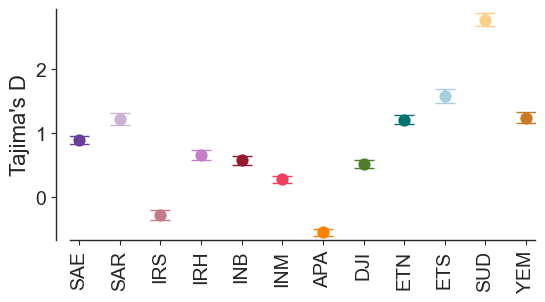

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt



## Plot pi

sns.set_style("ticks")
plt.figure(figsize=(6, 3))
# Pivot to long
t_long = pidf.iloc[[0] + list(range(15, 21))].T
# Plot pi
ax = sns.pointplot(
    x='cohort',
    y='tajima_d',
    data=t_long,
    order=pop_code_cols.keys(),
    errorbar=None,
    capsize=5,
    linestyles=None,
    palette=pop_code_cols,
    hue='cohort'
)

# Plot error bars
for i, row in t_long.iterrows():
    plt.errorbar(
        row['cohort'],
        row['tajima_d'],
        yerr=row['tajima_d_ci_err'],
        fmt='o',
        color=pop_code_cols[row['cohort']],
        capsize=7
    )


# Format axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)

#ax.spines['left'].set_bounds(0.005,0.013)

#ax.set_yticks(ticks)  # Remove x-ticks
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.spines['left'].set_position(('outward', 10))  # Move the left spine further to the left

# Remove x-axis completely
#ax.set_xticks([])  # Remove x-ticks
#ax.set_xticklabels([])  # Remove x-tick labels
#ax.spines['bottom'].set_visible(False)  # Remove x-axis spine

#set y ticks
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins = 4))
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14, rotation=90)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# set labs

plt.xlabel('')
plt.ylabel('Tajima\'s D', fontsize=16)
plt.savefig(f'../../figures/tD.svg', format='svg')



In [10]:
# select locations for spatial pi analysis
ids = ['M08', 'M18']
countries = ['Ethiopia','Djibouti','Sudan','Kenya']
df_locs = df_samples.query(f'pop_code != "COL" & sample_id != {ids} & country == {countries}')

count_loc = df_locs.groupby('location').count()['callset_order']

In [11]:
locs_over5 = count_loc[count_loc > 5].index
locs_all = count_loc.index
locs_all

Index(['Agaja', 'AlGalaa', 'AlHideiba', 'AlShukria', 'Arkaweet', 'Awash',
       'Babile', 'Danan', 'DireDawa', 'DjiboutiCity', 'Dubti', 'ElMeaileg',
       'ElSalamaniaWest', 'ElZedab', 'Galalabat', 'GeziraIslang', 'HaiElShati',
       'Haiya', 'Jiga', 'Karare', 'KebriDehar', 'Metehara', 'Modjo',
       'PortSudan', 'SouthShandi', 'Tabat', 'Wafara'],
      dtype='object', name='location')

In [12]:
dflist = []
for loc in locs_all:
    thetdf = diversity_stats(chrom='CM023248',
                             chromlen=93706023,
                             sample_query=f'location == "{loc}" & (sample_id != "M18" & sample_id != "M08")',
                             cohort_label=loc)
    dflist.append(thetdf)

subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:156: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_data = d_data / d_stdev_data
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_j = d_j / d_stdev_j
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:106: RuntimeWarning: invalid value encountered in scalar subtract
  bias = (n - 1) * (mean_jack_stat - stat_data)
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:110: RuntimeWarning: invalid value encountered in subtract
  (n - 1) * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat))


subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:156: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_data = d_data / d_stdev_data
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_j = d_j / d_stdev_j
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:106: RuntimeWarning: invalid value encountered in scalar subtract
  bias = (n - 1) * (mean_jack_stat - stat_data)
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:110: RuntimeWarning: invalid value encountered in subtract
  (n - 1) * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat))


subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:156: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_data = d_data / d_stdev_data
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_j = d_j / d_stdev_j
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:106: RuntimeWarning: invalid value encountered in scalar subtract
  bias = (n - 1) * (mean_jack_stat - stat_data)
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:110: RuntimeWarning: invalid value encountered in subtract
  (n - 1) * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat))


subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds
subsetting to accessible sites only
loaded ds


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:156: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_data = d_data / d_stdev_data
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  tajima_d_j = d_j / d_stdev_j
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:106: RuntimeWarning: invalid value encountered in scalar subtract
  bias = (n - 1) * (mean_jack_stat - stat_data)
/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_64688/1018325755.py:110: RuntimeWarning: invalid value encountered in subtract
  (n - 1) * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat))


subsetting to accessible sites only
loaded ds


In [13]:
# Now convert to a df and write out

#dflist = pd.concat(dflist, axis=1)
pi_df_loc = dflist[:2].T
pi_df_loc['n'] = count_loc.tolist()
pi_df_loc.columns = ['location', 'pi', 'count']
pi_df_loc.to_csv('~/Projects/AsGARD/data/pi_location.csv')

AttributeError: 'list' object has no attribute 'T'

In [28]:
#load ds
df_samples, ds = load_geno_ds(chrom='SM023248',
                sample_query='pop_code == "DJI"',
                )
print('loaded ds')
ac = allel.GenotypeArray(ds['call_genotype'].compute()).count_alleles()

subsetting to accessible sites only
loaded ds


In [34]:
sequence_length = 93706023

In [ ]:
def jackknife_ci(stat_data, jack_stat, confidence_level):
    """Compute a confidence interval from jackknife resampling.

    Parameters
    ----------
    stat_data : scalar
        Value of the statistic computed on all data.
    jack_stat : ndarray
        Values of the statistic computed for each jackknife resample.
    confidence_level : float
        Desired confidence level (e.g., 0.95).

    Returns
    -------
    estimate
        Bias-corrected "jackknifed estimate".
    bias
        Jackknife bias.
    std_err
        Standard error.
    ci_err
        Size of the confidence interval.
    ci_low
        Lower limit of confidence interval.
    ci_upp
        Upper limit of confidence interval.

    Notes
    -----
    N.B., this implementation is based on code from astropy, see:

    https://github.com/astropy/astropy/blob/8aba9632597e6bb489488109222bf2feff5835a6/astropy/stats/jackknife.py#L55

    """
    from scipy.special import erfinv  # type: ignore

    n = len(jack_stat)

    mean_jack_stat = np.mean(jack_stat)

    # jackknife bias
    bias = (n - 1) * (mean_jack_stat - stat_data)

    # jackknife standard error
    std_err = np.sqrt(
        (n - 1) * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat))
    )

    # bias-corrected "jackknifed estimate"
    estimate = stat_data - bias

    # confidence interval
    z_score = np.sqrt(2.0) * erfinv(confidence_level)
    ci_err = 2 * z_score * std_err
    ci_low, ci_upp = estimate + z_score * np.array((-std_err, std_err))

    return estimate, bias, std_err, ci_err, ci_low, ci_upp

def block_jackknife_cohort_diversity_stats(
    cohort_label, ac, n_jack, confidence_level, chromlen
    ):

        n_sites = ac.shape[0]
        ac = allel.AlleleCountsArray(ac)
        n = ac.sum(axis=1).max()  # number of chromosomes sampled
        n_sites = min(n_sites, ac.shape[0])  # number of sites
        block_length = n_sites // n_jack  # number of sites in each block
        n_sites_j = n_sites - block_length  # number of sites in each jackknife resample
        # Block length in BASE PAIRS (not number of sites)
        block_length_bp = chromlen / n_jack
    
    # Sequence length for each jackknife resample (removes one block)
        chromlen_j = chromlen - block_length_bp

        a1 = np.sum(1 / np.arange(1, n))
        a2 = np.sum(1 / (np.arange(1, n) ** 2))
        b1 = (n + 1) / (3 * (n - 1))
        b2 = 2 * (n**2 + n + 3) / (9 * n * (n - 1))
        c1 = b1 - (1 / a1)
        c2 = b2 - ((n + 2) / (a1 * n)) + (a2 / (a1**2))
        e1 = c1 / a1
        e2 = c2 / (a1**2 + a2)

        mpd_data = allel.mean_pairwise_difference(ac, fill=0)
        # N.B., here we compute the number of segregating sites as the number
        # of alleles minus 1. This follows the sgkit and tskit implementations,
        # and is different from scikit-allel.
        seg_data = ac.allelism() - 1

        theta_pi_abs_data = np.sum(mpd_data)
        theta_pi_data = theta_pi_abs_data / chromlen
        S_data = np.sum(seg_data)
        theta_w_abs_data = S_data / a1
        theta_w_data = theta_w_abs_data / n_sites
        d_data = theta_pi_abs_data - theta_w_abs_data
        d_stdev_data = np.sqrt((e1 * S_data) + (e2 * S_data * (S_data - 1)))
        tajima_d_data = d_data / d_stdev_data

        jack_theta_pi = []
        jack_theta_w = []
        jack_tajima_d = []

        for i in range(n_jack):
            # locate block to delete
            block_start = i * block_length
            block_stop = block_start + block_length
            loc_j = np.ones(n_sites, dtype=bool)
            loc_j[block_start:block_stop] = False
            assert np.count_nonzero(loc_j) == n_sites_j

            # resample data and compute statistics

            # theta_pi
            mpd_j = mpd_data[loc_j]
            theta_pi_abs_j = np.sum(mpd_j)
            theta_pi_j = theta_pi_abs_j / chromlen_j
            jack_theta_pi.append(theta_pi_j)

            # theta_w
            seg_j = seg_data[loc_j]
            S_j = np.sum(seg_j)
            theta_w_abs_j = S_j / a1
            theta_w_j = theta_w_abs_j / chromlen_j
            jack_theta_w.append(theta_w_j)

            # tajima_d
            d_j = theta_pi_abs_j - theta_w_abs_j
            d_stdev_j = np.sqrt((e1 * S_j) + (e2 * S_j * (S_j - 1)))
            tajima_d_j = d_j / d_stdev_j
            jack_tajima_d.append(tajima_d_j)

        # calculate jackknife stats
        (
            theta_pi_estimate,
            theta_pi_bias,
            theta_pi_std_err,
            theta_pi_ci_err,
            theta_pi_ci_low,
            theta_pi_ci_upp,
        ) = jackknife_ci(
            stat_data=theta_pi_data,
            jack_stat=jack_theta_pi,
            confidence_level=confidence_level,
        )
        (
            theta_w_estimate,
            theta_w_bias,
            theta_w_std_err,
            theta_w_ci_err,
            theta_w_ci_low,
            theta_w_ci_upp,
        ) = jackknife_ci(
            stat_data=theta_w_data,
            jack_stat=jack_theta_w,
            confidence_level=confidence_level,
        )
        (
            tajima_d_estimate,
            tajima_d_bias,
            tajima_d_std_err,
            tajima_d_ci_err,
            tajima_d_ci_low,
            tajima_d_ci_upp,
        ) = jackknife_ci(
            stat_data=tajima_d_data,
            jack_stat=jack_tajima_d,
            confidence_level=confidence_level,
        )

        return dict(
            cohort=cohort_label,
            theta_pi=theta_pi_data,
            theta_pi_estimate=theta_pi_estimate,
            theta_pi_bias=theta_pi_bias,
            theta_pi_std_err=theta_pi_std_err,
            theta_pi_ci_err=theta_pi_ci_err,
            theta_pi_ci_low=theta_pi_ci_low,
            theta_pi_ci_upp=theta_pi_ci_upp,
            theta_w=theta_w_data,
            theta_w_estimate=theta_w_estimate,
            theta_w_bias=theta_w_bias,
            theta_w_std_err=theta_w_std_err,
            theta_w_ci_err=theta_w_ci_err,
            theta_w_ci_low=theta_w_ci_low,
            theta_w_ci_upp=theta_w_ci_upp,
            tajima_d=tajima_d_data,
            tajima_d_estimate=tajima_d_estimate,
            tajima_d_bias=tajima_d_bias,
            tajima_d_std_err=tajima_d_std_err,
            tajima_d_ci_err=tajima_d_ci_err,
            tajima_d_ci_low=tajima_d_ci_low,
            tajima_d_ci_upp=tajima_d_ci_upp,
        )
def cohort_diversity_stats(
        chrom,
        chromlen,
        sample_query,
        cohort_label,
        random_seed = 42,
        n_jack= 200,
        confidence_level = 0.95,
    ):
    

        #load ds
        df_samples, ds = load_geno_ds(chrom=chrom,
                     sample_query=sample_query,
                     )
        print('loaded ds')
        ac = allel.GenotypeArray(ds['call_genotype'].compute()).count_alleles()

        stats = block_jackknife_cohort_diversity_stats(
            cohort_label=cohort_label,
            chromlen=chromlen,
            ac=ac,
            n_jack=n_jack,
            confidence_level=confidence_level,
        )

        extra_fields = [
            ("location", "unique"),
            ("country", "unique"),
            ("longitude", "mean"),
            ("latitude", "mean"),
        ]
        for field, agg in extra_fields:
            if agg == "unique":
                vals = df_samples[field].dropna().sort_values().unique()
                if len(vals) == 0:
                    val = np.nan
                elif len(vals) == 1:
                    val = vals[0]
                else:
                    val = vals.tolist()
            elif agg == "mean":
                vals = df_samples[field].dropna()
                if len(vals) == 0:
                    val = np.nan
                else:
                    val = np.mean(vals)
            else:
                val = np.nan
            stats[field] = val

        return pd.Series(stats)

def diversity_stats(
    chrom,
    chromlen,
    sample_query,
    cohort_label,
    random_seed = 42,
    n_jack= 200,
    confidence_level =  0.95,
):

    # Compute diversity stats for cohorts.
    stats = cohort_diversity_stats(
        chrom,
        chromlen,
        sample_query,
        cohort_label, 
        random_seed=random_seed,
        n_jack=n_jack,
        confidence_level=confidence_level
    )
    df_stats = pd.DataFrame(stats)

    return df_stats